In [2]:
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
import torch
import sklearn
import sklearn.cluster

class GCN_NET(torch.nn.Module):
    def __init__(self, nhid, nout, dropout):
        super().__init__()
        self.conv1 = GCNConv(data.num_node_features, nhid)
        self.conv2 = GCNConv(nhid,nout)
        self.dropout = dropout
    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x,self.dropout , training=self.training)
        x = self.conv2(x, edge_index)
        return x
def cluster(data, k, temp, num_iter, init = None, cluster_temp=5):
    '''
    pytorch (differentiable) implementation of soft k-means clustering.
    '''
    #normalize x so it lies on the unit sphere
    data = torch.diag(1./torch.norm(data, p=2, dim=1)) @ data
    #use kmeans++ initialization if nothing is provided
    if init is None:
        data_np = data.detach().numpy()
        norm = (data_np**2).sum(axis=1)
        init = sklearn.cluster.k_means_._k_init(data_np, k, norm, sklearn.utils.check_random_state(None))
        init = torch.tensor(init, requires_grad=True)
        if num_iter == 0: return init
    mu = init
    n = data.shape[0]
    d = data.shape[1]
#    data = torch.diag(1./torch.norm(data, dim=1, p=2))@data
    for t in range(num_iter):
        #get distances between all data points and cluster centers
#        dist = torch.cosine_similarity(data[:, None].expand(n, k, d).reshape((-1, d)), mu[None].expand(n, k, d).reshape((-1, d))).reshape((n, k))
        dist = data @ mu.t()
        #cluster responsibilities via softmax
        r = torch.softmax(cluster_temp*dist, 1)
        #total responsibility of each cluster
        cluster_r = r.sum(dim=0)
        #mean of points in each cluster weighted by responsibility
        cluster_mean = (r.t().unsqueeze(1) @ data.expand(k, *data.shape)).squeeze(1)
        #update cluster means
        new_mu = torch.diag(1/cluster_r) @ cluster_mean
        mu = new_mu
    dist = data @ mu.t()
    r = torch.softmax(cluster_temp*dist, 1)
    return mu, r, dist

class GCNClusterNet(torch.nn.Module):
    def __init__(self, nfeat, nhid, nout, dropout, K, cluster_temp):
        super(GCNClusterNet, self).__init__()
        self.GCN_NET = GCN_NET(nhid, nout, dropout)
        self.distmult = torch.nn.Parameter(torch.rand(nout))
        self.sigmoid = torch.nn.Sigmoid()
        self.K = K
        self.cluster_temp = cluster_temp
        self.init = torch.rand(self.K, nout)

    def forward(self,x,adj, num_iter=1):
    	#这里的x，adj没有用，为了方便对比本人把它们作为参数加了进来
        embeds = self.GCN_NET(data)
        mu_init, _, _ = cluster(embeds, self.K, 1, num_iter, cluster_temp=self.cluster_temp, init=self.init)
        mu, r, dist = cluster(embeds, self.K, 1, 1, cluster_temp=self.cluster_temp, init=mu_init.detach().clone())
        return mu, r, embeds, dist

In [3]:
def make_modularity_matrix(adj):
    adj = adj * (torch.ones(adj.shape[0], adj.shape[0]) - torch.eye(adj.shape[0]))
    degrees = adj.sum(axis=0).unsqueeze(1)
    mod = adj - degrees @ degrees.t() / adj.sum()
    return mod


def loss_modularity(r, bin_adj, mod):
    bin_adj_nodiag = bin_adj * (torch.ones(bin_adj.shape[0], bin_adj.shape[0]) - torch.eye(bin_adj.shape[0]))
    return (1. / bin_adj_nodiag.sum()) * (r.t() @ mod @ r).trace()

In [4]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import gc


##----------read nodes function-------------------------------------
def read_nodes(file_path, node_type):
    with open(file_path, 'r') as file:
        nodes = [line.strip() for line in file]
    node_data = {}
    for node_str in nodes:
        node_parts = node_str.split(',')
        node_id = node_type + node_parts[0]
        #features = list(map(float, node_parts[1:]))
        features = ''  ##For common community detection algorithm,you don't need any features.
        node_data[node_id] = {'node_type': node_type, 'features': features}
    return node_data


##--------------------------------------------------------------------


##------------read edge function-----------------------------------------------
def read_edges_incremental(file_path, edge_type, node_type_map):
    with open(file_path, 'r') as file:
        for line in file:
            edge_str = line.strip()
            edge_parts = edge_str.split(',')
            node1 = node_type_map[0] + edge_parts[0]
            node2 = node_type_map[1] + edge_parts[1]
            #features = list(map(float, edge_parts[2:]))
            features=''
            node1_type = node_type_map[0]
            node2_type = node_type_map[1]
            yield (node1, node2,
                   {'edge_type': edge_type, 'features': features})


##---------------------------------------------------------------------------------------


print("----start to read node.-----------------------")
app_nodes = read_nodes('telecom-graph//node_app.txt', 'app')
package_nodes = read_nodes('telecom-graph//node_package.txt', 'package')
user_nodes = read_nodes('telecom-graph//node_user.txt', 'user')
cell_nodes = read_nodes('telecom-graph//node_cell.txt', 'cell')
G = nx.Graph()
# 添加 package 节点并输出节点数量
for node_id, data in package_nodes.items():
    G.add_node(node_id, **data)
print(f"After adding package nodes: {len(G.nodes())} nodes")

# 添加 app 节点并输出节点数量
for node_id, data in app_nodes.items():
    G.add_node(node_id, **data)
print(f"After adding app nodes: {len(G.nodes())} nodes")

# 添加 user 节点并输出节点数量
for node_id, data in user_nodes.items():
    G.add_node(node_id, **data)
print(f"After adding user nodes: {len(G.nodes())} nodes")

# 添加 cell 节点并输出节点数量
for node_id, data in cell_nodes.items():
    G.add_node(node_id, **data)
print(f"After adding cell nodes: {len(G.nodes())} nodes")
print("-----all nodes is read already.----------------")

print("----------start to read edge.----------------------")

print("----------1--------------------")
for edge in read_edges_incremental('telecom-graph//edge_user_buy_package.txt', 'buy',
                                   ['user', 'package']):
    G.add_edge(edge[0], edge[1], **edge[2])
# 打印图的信息，检查是否添加了边
print(f"After first addition, number of edges: {G.number_of_edges()}")
# 进行垃圾回收，释放内存
gc.collect()

print("----------2--------------------")
for edge in read_edges_incremental('telecom-graph//edge_user_live_cell.txt', 'live',
                                   ['user', 'cell']):
    G.add_edge(edge[0], edge[1], **edge[2])

# 进行垃圾回收，释放内存
gc.collect()
print(f"After second addition, number of edges: {G.number_of_edges()}")
print("----------3--------------------")
for edge in read_edges_incremental('telecom-graph//edge_user_use_app.txt', 'use',
                                   ['user', 'app']):
    G.add_edge(edge[0], edge[1], **edge[2])

# 进行垃圾回收，释放内存
gc.collect()
print(f"After third addition, number of edges: {G.number_of_edges()}")
print("---------all edge is read already.------------------")

#nx.write_graphml(G, "telecom_network_1.graphml")
#print("Writing done!!")

----start to read node.-----------------------
After adding package nodes: 380 nodes
After adding app nodes: 1380 nodes
After adding user nodes: 101380 nodes
After adding cell nodes: 170380 nodes
-----all nodes is read already.----------------
----------start to read edge.----------------------
----------1--------------------
After first addition, number of edges: 1900000
----------2--------------------
After second addition, number of edges: 8800000
----------3--------------------
After third addition, number of edges: 8900000
---------all edge is read already.------------------


Node Number: 170380
Edge Number: 8900000
Graph Density: 0.0006131762477201892
connected_components: 20
Mean Degree: 104.47235591031811


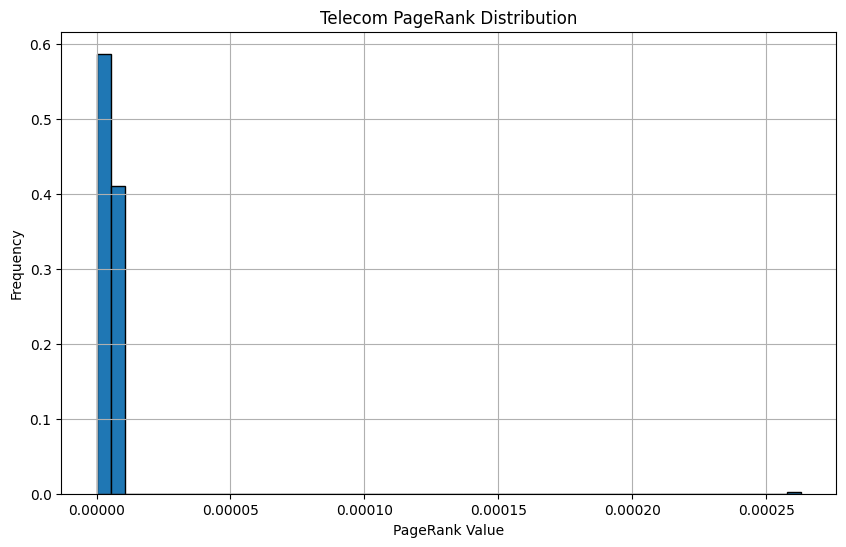

In [8]:
import community as community_louvain  # Louvain community detection
num_nodes = G.number_of_nodes()
num_edges = G.number_of_edges()
print(f'Node Number: {num_nodes}')
print(f'Edge Number: {num_edges}')
    
density = nx.density(G)
print(f'Graph Density: {density}')
connected_components = list(nx.connected_components(G))
num_connected_components = len(connected_components)
print(f'connected_components: {num_connected_components}')
# 节点度数和平均度数
degree_sequence = [d for n, d in G.degree()]
average_degree = np.mean(degree_sequence)
print(f'Mean Degree: {average_degree}')
# 计算 PageRank
pagerank = nx.pagerank(G)
pagerank_values = list(pagerank.values())

# 计算 PageRank 的频率
pagerank_count = np.histogram(pagerank_values, bins=50, range=(0, max(pagerank_values)))[0]
pagerank_bins = np.histogram(pagerank_values, bins=50, range=(0, max(pagerank_values)))[1]

# 绘制 PageRank 分布图
plt.figure(figsize=(10, 6))
plt.bar(pagerank_bins[:-1], pagerank_count / len(pagerank_values), width=np.diff(pagerank_bins), edgecolor='black', align='edge')
plt.xlabel('PageRank Value')
plt.ylabel('Frequency')
plt.title('Telecom PageRank Distribution')
plt.grid(True)
plt.show()


In [9]:
connected_components = list(nx.connected_components(G))
subgraph = G.subgraph(connected_components[0])
mapping = {node: i for i, node in enumerate(subgraph.nodes())}
reverse_mapping = {i: node for node, i in mapping.items()}
integer_subgraph = nx.relabel_nodes(subgraph, mapping)

# 节点数和边数


Node Number: 8519
Edge Number: 445000
Graph Density: 0.012264892687287874
connected_components: 1
Mean Degree: 104.47235591031811


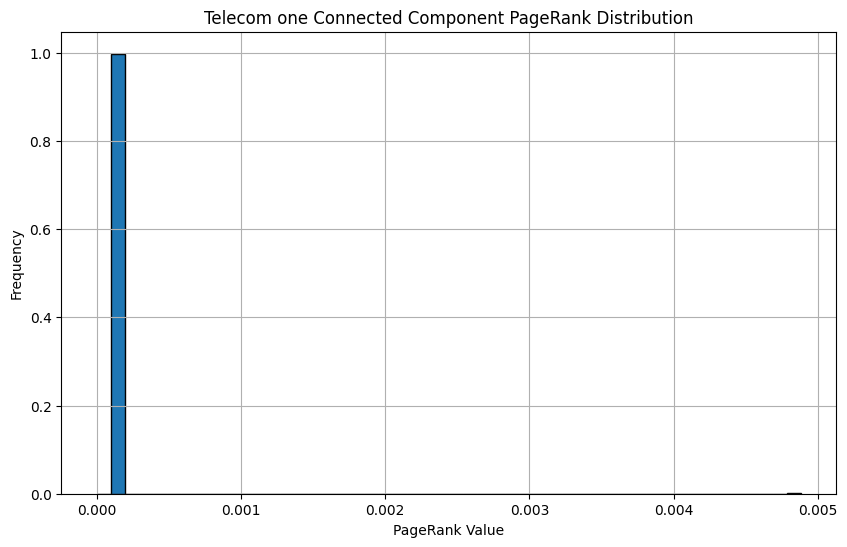

In [8]:
num_nodes = integer_subgraph.number_of_nodes()
num_edges = integer_subgraph.number_of_edges()
print(f'Node Number: {num_nodes}')
print(f'Edge Number: {num_edges}')
    
density = nx.density(integer_subgraph)
print(f'Graph Density: {density}')
connected_components = list(nx.connected_components(integer_subgraph))
num_connected_components = len(connected_components)
print(f'connected_components: {num_connected_components}')
# 节点度数和平均度数
degree_sequence = [d for n, d in integer_subgraph.degree()]
average_degree = np.mean(degree_sequence)
print(f'Mean Degree: {average_degree}')
# 计算 PageRank
pagerank = nx.pagerank(integer_subgraph)
pagerank_values = list(pagerank.values())

# 计算 PageRank 的频率
pagerank_count = np.histogram(pagerank_values, bins=50, range=(0, max(pagerank_values)))[0]
pagerank_bins = np.histogram(pagerank_values, bins=50, range=(0, max(pagerank_values)))[1]

# 绘制 PageRank 分布图
plt.figure(figsize=(10, 6))
plt.bar(pagerank_bins[:-1], pagerank_count / len(pagerank_values), width=np.diff(pagerank_bins), edgecolor='black', align='edge')
plt.xlabel('PageRank Value')
plt.ylabel('Frequency')
plt.title('Telecom one Connected Component PageRank Distribution')
plt.grid(True)
plt.show()


In [10]:
from torch_geometric.datasets import Planetoid
from torch_geometric.utils import to_dense_adj, to_scipy_sparse_matrix, from_scipy_sparse_matrix
import scipy.sparse as sp
import numpy as np
from torch_geometric.data import Data

partition_louvain = community_louvain.best_partition(integer_subgraph)
# 获取所有唯一的社区标签
communities = list(set(partition_louvain.values()))
print(communities)
# 为每个社区生成独热编码向量
embedding_dim = len(communities)
community_embeddings = {community: np.eye(embedding_dim)[i] for i, community in enumerate(communities)}

# 将每个节点的初始嵌入赋值为它所属社区的独热编码
node_embeddings = np.array([community_embeddings[partition_louvain[node]] for node in integer_subgraph.nodes()])
def networkx_to_pyg_with_masks(G, num_train=0.8, num_val=0.1, num_test=0.1,node_embeddings=None):
    # Number of nodes
    num_nodes = len(G.nodes)
    # Check if nodes have features; if not, initialize with zero features
    if node_embeddings.all()==None:
        features =torch.randn((num_nodes, 50), dtype=torch.float)
        print("Random Generate")
    else:
        # Assuming nodes are indexed from 0 to num_nodes - 1
        features =torch.tensor(node_embeddings, dtype=torch.float)
    # Extract edges
    edge_index = torch.tensor(list(G.edges), dtype=torch.long).t().contiguous()
    # Extract adjacency matrix and convert to tensor
    adj = nx.adjacency_matrix(G).todense()
    adj = torch.tensor(adj, dtype=torch.float)
    # Generate masks
    indices = torch.randperm(num_nodes)
    num_train_nodes = int(num_nodes * num_train)
    num_val_nodes = int(num_nodes * num_val)
    train_idx = indices[:num_train_nodes]
    val_idx = indices[num_train_nodes:num_train_nodes + num_val_nodes]
    test_idx = indices[num_train_nodes + num_val_nodes:]
    # Create masks
    train_mask = torch.zeros(num_nodes, dtype=torch.bool)
    val_mask = torch.zeros(num_nodes, dtype=torch.bool)
    test_mask = torch.zeros(num_nodes, dtype=torch.bool)
    train_mask[train_idx] = True
    val_mask[val_idx] = True
    test_mask[test_idx] = True
    # No labels provided, so y is None
    y = torch.zeros((num_nodes, 1), dtype=torch.float)
    data = Data(x=features, edge_index=edge_index, y=y, train_mask=train_mask, val_mask=val_mask, test_mask=test_mask)
    return data
data=networkx_to_pyg_with_masks(integer_subgraph,node_embeddings=node_embeddings)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]


In [11]:
data

Data(x=[8519, 50], edge_index=[2, 445000], y=[8519, 1], train_mask=[8519], val_mask=[8519], test_mask=[8519])

In [12]:
# 将 edge_index 转换为稠密的邻接矩阵
adj = to_dense_adj(data.edge_index)[0]
def normalize(mx):
    rowsum = np.array(mx.sum(1))  # 矩阵行求和
    r_inv = np.power(rowsum, -1).flatten()  # 每行和的-1次方
    r_inv[np.isinf(r_inv)] = 0.  # 如果是inf，转换为0
    r_mat_inv = sp.diags(r_inv)  # 转换为对角阵
    mx = r_mat_inv.dot(mx)  # D-1*A,乘上特征，按行归一化
    return mx
def sparse_mx_to_torch_sparse_tensor(sparse_mx):
    sparse_mx = sparse_mx.tocoo().astype(np.float32)
    indices = torch.from_numpy(
        np.vstack((sparse_mx.row, sparse_mx.col)).astype(np.int64))
    values = torch.from_numpy(sparse_mx.data)
    shape = torch.Size(sparse_mx.shape)
    return torch.sparse.FloatTensor(indices, values, shape)
features = sp.csr_matrix(data.x, dtype=np.float32)  # 取特征

adj = sp.coo_matrix((np.ones(data.edge_index.shape[1]), (data.edge_index[0, :], data.edge_index[1, :])),
                    shape=(data.y.shape[0], data.y.shape[0]), dtype=np.float32)
adj = adj + adj.T.multiply(adj.T > adj) - adj.multiply(adj.T > adj)

features = normalize(features)  # 特征归一化
adj = normalize(adj + sp.eye(adj.shape[0]))  # A+I归一化
features = torch.FloatTensor(np.array(features.todense()))# 将numpy的数据转换成torch格式
adj = sparse_mx_to_torch_sparse_tensor(adj)

adj = adj.coalesce()

bin_adj_all = (adj.to_dense() > 0).float()
print(bin_adj_all)

tensor([[1., 0., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.]])


In [12]:
model_cluster = GCNClusterNet(nfeat=50, nhid=128, nout=50, dropout=0.1, K=35, cluster_temp=50)
bin_adj_all = (adj.to_dense() > 0).float()
optimizer = torch.optim.Adam(model_cluster.parameters(), lr=0.001, weight_decay=5e-4)
test_object = make_modularity_matrix(bin_adj_all)
model_cluster.train()
num_cluster_iter = 1
losses = []

for epoch in range(200):
    mu, r, embeds, dist = model_cluster(features, adj, num_cluster_iter)
    loss = loss_modularity(r, bin_adj_all, test_object)
    loss = -loss
    optimizer.zero_grad()
    loss.backward()
    if epoch == 100:
        num_cluster_iter = 10
    if epoch % 100 == 0:
        r = torch.softmax(100 * r, dim=1)
    loss_test = loss_modularity(r, bin_adj_all, test_object)
    if epoch == 0:
        best_train_val = 100
    if loss.item() < best_train_val:
        best_train_val = loss.item()
        curr_test_loss = loss_test.item()
        # convert distances into a feasible (fractional x)#将距离转换为可行的（分数x）
        x_best = torch.softmax(dist * 100, 0).sum(dim=1)
        x_best = 2 * (torch.sigmoid(4 * x_best) - 0.5)
        if x_best.sum() > 5:
            x_best = 5 * x_best / x_best.sum()
    losses.append(loss.item())
    optimizer.step()
    if epoch%10==0:
        print(f'epoch{epoch + 1}   ClusterNet value:{curr_test_loss}')

epoch1   ClusterNet value:0.7337773442268372
epoch11   ClusterNet value:0.7408832311630249
epoch21   ClusterNet value:0.7440953254699707
epoch31   ClusterNet value:0.7440953254699707
epoch41   ClusterNet value:0.7440953254699707
epoch51   ClusterNet value:0.7440953254699707
epoch61   ClusterNet value:0.7458380460739136
epoch71   ClusterNet value:0.7458380460739136
epoch81   ClusterNet value:0.7491424679756165
epoch91   ClusterNet value:0.7491424679756165
epoch101   ClusterNet value:0.7505381107330322
epoch111   ClusterNet value:0.7505381107330322
epoch121   ClusterNet value:0.7505381107330322
epoch131   ClusterNet value:0.7505381107330322
epoch141   ClusterNet value:0.7574965357780457
epoch151   ClusterNet value:0.7574965357780457
epoch161   ClusterNet value:0.7574965357780457
epoch171   ClusterNet value:0.7577881813049316
epoch181   ClusterNet value:0.7577881813049316
epoch191   ClusterNet value:0.7586315870285034


In [15]:
model_cluster = GCNClusterNet(nfeat=50, nhid=128, nout=50, dropout=0.1, K=35, cluster_temp=50)
bin_adj_all = (adj.to_dense() > 0).float()
optimizer = torch.optim.Adam(model_cluster.parameters(), lr=0.05, weight_decay=5e-4)
test_object = make_modularity_matrix(bin_adj_all)
model_cluster.train()
num_cluster_iter = 1
losses = []
Value_LR_0=[]
for epoch in range(200):
    mu, r, embeds, dist = model_cluster(features, adj, num_cluster_iter)
    loss = loss_modularity(r, bin_adj_all, test_object)
    loss = -loss
    optimizer.zero_grad()
    loss.backward()
    if epoch == 100:
        num_cluster_iter = 10
    if epoch % 100 == 0:
        r = torch.softmax(100 * r, dim=1)
    loss_test = loss_modularity(r, bin_adj_all, test_object)
    if epoch == 0:
        best_train_val = 100
    if loss.item() < best_train_val:
        best_train_val = loss.item()
        curr_test_loss = loss_test.item()
        # convert distances into a feasible (fractional x)#将距离转换为可行的（分数x）
        x_best = torch.softmax(dist * 100, 0).sum(dim=1)
        x_best = 2 * (torch.sigmoid(4 * x_best) - 0.5)
        if x_best.sum() > 5:
            x_best = 5 * x_best / x_best.sum()
    losses.append(loss.item())
    optimizer.step()
    if epoch%10==0:
        print(f'epoch{epoch + 1}   ClusterNet value:{curr_test_loss}')
        Value_LR_0.append(curr_test_loss)

epoch1   ClusterNet value:0.7173280715942383
epoch11   ClusterNet value:0.685192883014679
epoch21   ClusterNet value:0.6883136034011841
epoch31   ClusterNet value:0.6940404772758484
epoch41   ClusterNet value:0.6996961236000061
epoch51   ClusterNet value:0.6996961236000061
epoch61   ClusterNet value:0.6996961236000061
epoch71   ClusterNet value:0.6996961236000061
epoch81   ClusterNet value:0.6996961236000061
epoch91   ClusterNet value:0.6996961236000061
epoch101   ClusterNet value:0.7017052173614502
epoch111   ClusterNet value:0.7045501470565796
epoch121   ClusterNet value:0.7228401899337769
epoch131   ClusterNet value:0.723320484161377
epoch141   ClusterNet value:0.7294619679450989
epoch151   ClusterNet value:0.7294619679450989
epoch161   ClusterNet value:0.7294619679450989
epoch171   ClusterNet value:0.7294619679450989
epoch181   ClusterNet value:0.7294619679450989
epoch191   ClusterNet value:0.7294619679450989


In [19]:
model_cluster = GCNClusterNet(nfeat=50, nhid=128, nout=50, dropout=0.1, K=35, cluster_temp=50)
bin_adj_all = (adj.to_dense() > 0).float()
optimizer = torch.optim.Adam(model_cluster.parameters(), lr=0.001, weight_decay=5e-4)
test_object = make_modularity_matrix(bin_adj_all)
model_cluster.train()
num_cluster_iter = 1
losses = []
Value_LR_1=[]
for epoch in range(200):
    mu, r, embeds, dist = model_cluster(features, adj, num_cluster_iter)
    loss = loss_modularity(r, bin_adj_all, test_object)
    loss = -loss
    optimizer.zero_grad()
    loss.backward()
    if epoch == 100:
        num_cluster_iter = 10
    if epoch % 100 == 0:
        r = torch.softmax(100 * r, dim=1)
    loss_test = loss_modularity(r, bin_adj_all, test_object)
    if epoch == 0:
        best_train_val = 100
    if loss.item() < best_train_val:
        best_train_val = loss.item()
        curr_test_loss = loss_test.item()
        # convert distances into a feasible (fractional x)#将距离转换为可行的（分数x）
        x_best = torch.softmax(dist * 100, 0).sum(dim=1)
        x_best = 2 * (torch.sigmoid(4 * x_best) - 0.5)
        if x_best.sum() > 5:
            x_best = 5 * x_best / x_best.sum()
    losses.append(loss.item())
    optimizer.step()
    if epoch%10==0:
        print(f'epoch{epoch + 1}   ClusterNet value:{curr_test_loss}')
        Value_LR_1.append(curr_test_loss)

epoch1   ClusterNet value:0.7352981567382812
epoch11   ClusterNet value:0.73479825258255
epoch21   ClusterNet value:0.73479825258255
epoch31   ClusterNet value:0.7418968677520752
epoch41   ClusterNet value:0.7418968677520752
epoch51   ClusterNet value:0.7418968677520752
epoch61   ClusterNet value:0.7418968677520752
epoch71   ClusterNet value:0.7418968677520752
epoch81   ClusterNet value:0.7418968677520752
epoch91   ClusterNet value:0.7418968677520752
epoch101   ClusterNet value:0.7418968677520752
epoch111   ClusterNet value:0.7461404800415039
epoch121   ClusterNet value:0.7489970922470093
epoch131   ClusterNet value:0.7499839067459106
epoch141   ClusterNet value:0.7499839067459106
epoch151   ClusterNet value:0.7499839067459106
epoch161   ClusterNet value:0.7499839067459106
epoch171   ClusterNet value:0.7499839067459106
epoch181   ClusterNet value:0.7499839067459106
epoch191   ClusterNet value:0.7499839067459106


In [20]:
model_cluster = GCNClusterNet(nfeat=50, nhid=128, nout=50, dropout=0.1, K=35, cluster_temp=50)
bin_adj_all = (adj.to_dense() > 0).float()
optimizer = torch.optim.Adam(model_cluster.parameters(), lr=0.0001, weight_decay=5e-4)
test_object = make_modularity_matrix(bin_adj_all)
model_cluster.train()
num_cluster_iter = 1
losses = []
Value_LR_2=[]
for epoch in range(200):
    mu, r, embeds, dist = model_cluster(features, adj, num_cluster_iter)
    loss = loss_modularity(r, bin_adj_all, test_object)
    loss = -loss
    optimizer.zero_grad()
    loss.backward()
    if epoch == 100:
        num_cluster_iter = 10
    if epoch % 100 == 0:
        r = torch.softmax(100 * r, dim=1)
    loss_test = loss_modularity(r, bin_adj_all, test_object)
    if epoch == 0:
        best_train_val = 100
    if loss.item() < best_train_val:
        best_train_val = loss.item()
        curr_test_loss = loss_test.item()
        # convert distances into a feasible (fractional x)#将距离转换为可行的（分数x）
        x_best = torch.softmax(dist * 100, 0).sum(dim=1)
        x_best = 2 * (torch.sigmoid(4 * x_best) - 0.5)
        if x_best.sum() > 5:
            x_best = 5 * x_best / x_best.sum()
    losses.append(loss.item())
    optimizer.step()
    if epoch%10==0:
        print(f'epoch{epoch + 1}   ClusterNet value:{curr_test_loss}')
        Value_LR_2.append(curr_test_loss)

epoch1   ClusterNet value:0.7432840466499329
epoch11   ClusterNet value:0.717830240726471
epoch21   ClusterNet value:0.7187989950180054
epoch31   ClusterNet value:0.7288190126419067
epoch41   ClusterNet value:0.7288190126419067
epoch51   ClusterNet value:0.7295617461204529
epoch61   ClusterNet value:0.7295617461204529
epoch71   ClusterNet value:0.7295617461204529
epoch81   ClusterNet value:0.7439765930175781
epoch91   ClusterNet value:0.7439765930175781
epoch101   ClusterNet value:0.7443041801452637
epoch111   ClusterNet value:0.7550567984580994
epoch121   ClusterNet value:0.7550567984580994
epoch131   ClusterNet value:0.7564818263053894
epoch141   ClusterNet value:0.756530225276947
epoch151   ClusterNet value:0.756530225276947
epoch161   ClusterNet value:0.756530225276947
epoch171   ClusterNet value:0.7577269077301025
epoch181   ClusterNet value:0.7577269077301025
epoch191   ClusterNet value:0.7588424682617188


In [21]:
model_cluster = GCNClusterNet(nfeat=50, nhid=128, nout=50, dropout=0.1, K=35, cluster_temp=50)
bin_adj_all = (adj.to_dense() > 0).float()
optimizer = torch.optim.Adam(model_cluster.parameters(), lr=5e-5, weight_decay=5e-4)
test_object = make_modularity_matrix(bin_adj_all)
model_cluster.train()
num_cluster_iter = 1
losses = []
Value_LR_3=[]
for epoch in range(200):
    mu, r, embeds, dist = model_cluster(features, adj, num_cluster_iter)
    loss = loss_modularity(r, bin_adj_all, test_object)
    loss = -loss
    optimizer.zero_grad()
    loss.backward()
    if epoch == 100:
        num_cluster_iter = 10
    if epoch % 100 == 0:
        r = torch.softmax(100 * r, dim=1)
    loss_test = loss_modularity(r, bin_adj_all, test_object)
    if epoch == 0:
        best_train_val = 100
    if loss.item() < best_train_val:
        best_train_val = loss.item()
        curr_test_loss = loss_test.item()
        # convert distances into a feasible (fractional x)#将距离转换为可行的（分数x）
        x_best = torch.softmax(dist * 100, 0).sum(dim=1)
        x_best = 2 * (torch.sigmoid(4 * x_best) - 0.5)
        if x_best.sum() > 5:
            x_best = 5 * x_best / x_best.sum()
    losses.append(loss.item())
    optimizer.step()
    if epoch%10==0:
        print(f'epoch{epoch + 1}   ClusterNet value:{curr_test_loss}')
        Value_LR_3.append(curr_test_loss)

epoch1   ClusterNet value:0.7224969267845154
epoch11   ClusterNet value:0.6834889054298401
epoch21   ClusterNet value:0.700247585773468
epoch31   ClusterNet value:0.700247585773468
epoch41   ClusterNet value:0.7024336457252502
epoch51   ClusterNet value:0.7075635194778442
epoch61   ClusterNet value:0.7139977812767029
epoch71   ClusterNet value:0.7186189889907837
epoch81   ClusterNet value:0.7369179129600525
epoch91   ClusterNet value:0.7376776933670044
epoch101   ClusterNet value:0.7401160001754761
epoch111   ClusterNet value:0.7559988498687744
epoch121   ClusterNet value:0.7578185200691223
epoch131   ClusterNet value:0.7578185200691223
epoch141   ClusterNet value:0.7578185200691223
epoch151   ClusterNet value:0.7578185200691223
epoch161   ClusterNet value:0.7578185200691223
epoch171   ClusterNet value:0.7578185200691223
epoch181   ClusterNet value:0.7578185200691223
epoch191   ClusterNet value:0.7578185200691223


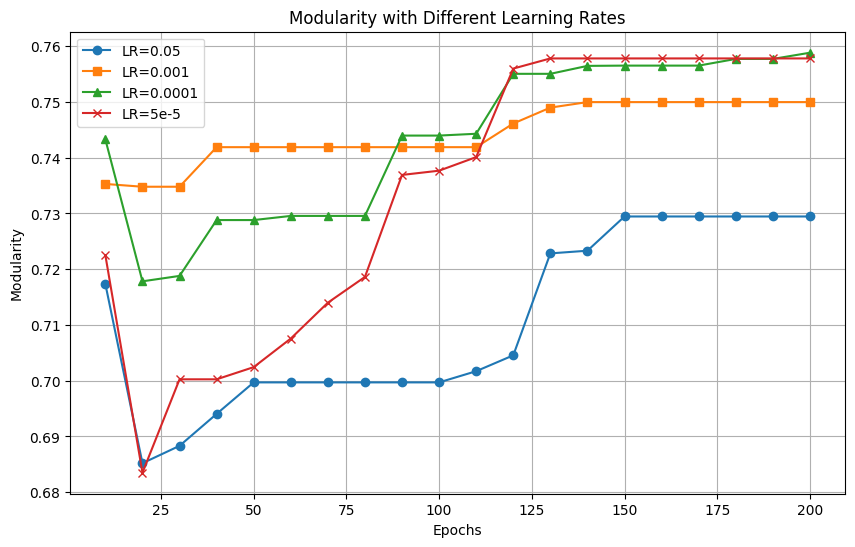

In [23]:
Value_LR_0#LR=0.05
Value_LR_1#LR=0.001
Value_LR_2#LR=0.0001
Value_LR_3#LR=5e-5
import matplotlib.pyplot as plt
import numpy as np

# 示例数据：每个学习率的训练值
epochs = np.arange(10, 201, 10)  # 从 10 到 200，步长为 10
# 创建图形和轴
plt.figure(figsize=(10, 6))

# 绘制每个学习率的训练值
plt.plot(epochs, Value_LR_0, label='LR=0.05', marker='o')
plt.plot(epochs, Value_LR_1, label='LR=0.001', marker='s')
plt.plot(epochs, Value_LR_2, label='LR=0.0001', marker='^')
plt.plot(epochs, Value_LR_3, label='LR=5e-5', marker='x')

# 添加标签和标题
plt.xlabel('Epochs')
plt.ylabel('Modularity')
plt.title('Modularity with Different Learning Rates')
plt.legend()  # 显示图例

# 显示图形
plt.grid(True)
plt.show()

In [36]:
model_cluster = GCNClusterNet(nfeat=50, nhid=128, nout=50, dropout=0.1, K=35, cluster_temp=50)
bin_adj_all = (adj.to_dense() > 0).float()
optimizer = torch.optim.Adam(model_cluster.parameters(), lr=0.001, weight_decay=5e-5)
test_object = make_modularity_matrix(bin_adj_all)
model_cluster.train()
num_cluster_iter = 1
losses = []
value_dropout_0=[]
for epoch in range(200):
    mu, r, embeds, dist = model_cluster(features, adj, num_cluster_iter)
    loss = loss_modularity(r, bin_adj_all, test_object)
    loss = -loss
    optimizer.zero_grad()
    loss.backward()
    if epoch == 100:
        num_cluster_iter = 10
    if epoch % 100 == 0:
        r = torch.softmax(100 * r, dim=1)
    loss_test = loss_modularity(r, bin_adj_all, test_object)
    if epoch == 0:
        best_train_val = 100
    if loss.item() < best_train_val:
        best_train_val = loss.item()
        curr_test_loss = loss_test.item()
        # convert distances into a feasible (fractional x)#将距离转换为可行的（分数x）
        x_best = torch.softmax(dist * 100, 0).sum(dim=1)
        x_best = 2 * (torch.sigmoid(4 * x_best) - 0.5)
        if x_best.sum() > 5:
            x_best = 5 * x_best / x_best.sum()
    losses.append(loss.item())
    optimizer.step()
    if epoch%10==0:
        print(f'epoch{epoch + 1}   ClusterNet value:{curr_test_loss}')
        value_dropout_0.append(curr_test_loss)


epoch1   ClusterNet value:0.7311229109764099
epoch11   ClusterNet value:0.7462844848632812
epoch21   ClusterNet value:0.7462844848632812
epoch31   ClusterNet value:0.7462844848632812
epoch41   ClusterNet value:0.7475616335868835
epoch51   ClusterNet value:0.7475616335868835
epoch61   ClusterNet value:0.7475616335868835
epoch71   ClusterNet value:0.7475616335868835
epoch81   ClusterNet value:0.7475616335868835
epoch91   ClusterNet value:0.748755156993866
epoch101   ClusterNet value:0.748755156993866
epoch111   ClusterNet value:0.748755156993866
epoch121   ClusterNet value:0.748755156993866
epoch131   ClusterNet value:0.748755156993866
epoch141   ClusterNet value:0.748755156993866
epoch151   ClusterNet value:0.748755156993866
epoch161   ClusterNet value:0.748755156993866
epoch171   ClusterNet value:0.748755156993866
epoch181   ClusterNet value:0.748755156993866
epoch191   ClusterNet value:0.748755156993866


In [31]:
model_cluster = GCNClusterNet(nfeat=50, nhid=128, nout=50, dropout=0.1, K=35, cluster_temp=50)
bin_adj_all = (adj.to_dense() > 0).float()
optimizer = torch.optim.Adam(model_cluster.parameters(), lr=0.001, weight_decay=5e-4)
test_object = make_modularity_matrix(bin_adj_all)
model_cluster.train()
num_cluster_iter = 1
losses = []
value_dropout_1=[]
for epoch in range(200):
    mu, r, embeds, dist = model_cluster(features, adj, num_cluster_iter)
    loss = loss_modularity(r, bin_adj_all, test_object)
    loss = -loss
    optimizer.zero_grad()
    loss.backward()
    if epoch == 100:
        num_cluster_iter = 10
    if epoch % 100 == 0:
        r = torch.softmax(100 * r, dim=1)
    loss_test = loss_modularity(r, bin_adj_all, test_object)
    if epoch == 0:
        best_train_val = 100
    if loss.item() < best_train_val:
        best_train_val = loss.item()
        curr_test_loss = loss_test.item()
        # convert distances into a feasible (fractional x)#将距离转换为可行的（分数x）
        x_best = torch.softmax(dist * 100, 0).sum(dim=1)
        x_best = 2 * (torch.sigmoid(4 * x_best) - 0.5)
        if x_best.sum() > 5:
            x_best = 5 * x_best / x_best.sum()
    losses.append(loss.item())
    optimizer.step()
    if epoch%10==0:
        print(f'epoch{epoch + 1}   ClusterNet value:{curr_test_loss}')
        value_dropout_1.append(curr_test_loss)

epoch1   ClusterNet value:0.7215337157249451
epoch11   ClusterNet value:0.7488670945167542
epoch21   ClusterNet value:0.7488670945167542
epoch31   ClusterNet value:0.7510123252868652
epoch41   ClusterNet value:0.7535737752914429
epoch51   ClusterNet value:0.7535737752914429
epoch61   ClusterNet value:0.7535737752914429
epoch71   ClusterNet value:0.7539469599723816
epoch81   ClusterNet value:0.7539469599723816
epoch91   ClusterNet value:0.7539469599723816
epoch101   ClusterNet value:0.7539469599723816
epoch111   ClusterNet value:0.7539469599723816
epoch121   ClusterNet value:0.7539469599723816
epoch131   ClusterNet value:0.7539469599723816
epoch141   ClusterNet value:0.7568740248680115
epoch151   ClusterNet value:0.7568740248680115
epoch161   ClusterNet value:0.7568740248680115
epoch171   ClusterNet value:0.7568740248680115
epoch181   ClusterNet value:0.7568740248680115
epoch191   ClusterNet value:0.758141279220581


In [33]:
model_cluster = GCNClusterNet(nfeat=50, nhid=128, nout=50, dropout=0.1, K=35, cluster_temp=50)
bin_adj_all = (adj.to_dense() > 0).float()
optimizer = torch.optim.Adam(model_cluster.parameters(), lr=0.001, weight_decay=0.001)
test_object = make_modularity_matrix(bin_adj_all)
model_cluster.train()
num_cluster_iter = 1
losses = []
value_dropout_2=[]
for epoch in range(200):
    mu, r, embeds, dist = model_cluster(features, adj, num_cluster_iter)
    loss = loss_modularity(r, bin_adj_all, test_object)
    loss = -loss
    optimizer.zero_grad()
    loss.backward()
    if epoch == 100:
        num_cluster_iter = 10
    if epoch % 100 == 0:
        r = torch.softmax(100 * r, dim=1)
    loss_test = loss_modularity(r, bin_adj_all, test_object)
    if epoch == 0:
        best_train_val = 100
    if loss.item() < best_train_val:
        best_train_val = loss.item()
        curr_test_loss = loss_test.item()
        # convert distances into a feasible (fractional x)#将距离转换为可行的（分数x）
        x_best = torch.softmax(dist * 100, 0).sum(dim=1)
        x_best = 2 * (torch.sigmoid(4 * x_best) - 0.5)
        if x_best.sum() > 5:
            x_best = 5 * x_best / x_best.sum()
    losses.append(loss.item())
    optimizer.step()
    if epoch%10==0:
        print(f'epoch{epoch + 1}   ClusterNet value:{curr_test_loss}')
        value_dropout_2.append(curr_test_loss)

epoch1   ClusterNet value:0.7133559584617615
epoch11   ClusterNet value:0.7400056719779968
epoch21   ClusterNet value:0.7485650181770325
epoch31   ClusterNet value:0.7485650181770325
epoch41   ClusterNet value:0.7485650181770325
epoch51   ClusterNet value:0.7496592998504639
epoch61   ClusterNet value:0.7496592998504639
epoch71   ClusterNet value:0.7496592998504639
epoch81   ClusterNet value:0.7496592998504639
epoch91   ClusterNet value:0.7502541542053223
epoch101   ClusterNet value:0.7502541542053223
epoch111   ClusterNet value:0.7502541542053223
epoch121   ClusterNet value:0.7544050216674805
epoch131   ClusterNet value:0.7550088763237
epoch141   ClusterNet value:0.755405068397522
epoch151   ClusterNet value:0.755405068397522
epoch161   ClusterNet value:0.7558987736701965
epoch171   ClusterNet value:0.7560325264930725
epoch181   ClusterNet value:0.7561944127082825
epoch191   ClusterNet value:0.7562574744224548


In [29]:
model_cluster = GCNClusterNet(nfeat=50, nhid=128, nout=50, dropout=0.1, K=35, cluster_temp=50)
bin_adj_all = (adj.to_dense() > 0).float()
optimizer = torch.optim.Adam(model_cluster.parameters(), lr=0.001, weight_decay=0.01)
test_object = make_modularity_matrix(bin_adj_all)
model_cluster.train()
num_cluster_iter = 1
losses = []
value_dropout_3=[]
for epoch in range(200):
    mu, r, embeds, dist = model_cluster(features, adj, num_cluster_iter)
    loss = loss_modularity(r, bin_adj_all, test_object)
    loss = -loss
    optimizer.zero_grad()
    loss.backward()
    if epoch == 100:
        num_cluster_iter = 10
    if epoch % 100 == 0:
        r = torch.softmax(100 * r, dim=1)
    loss_test = loss_modularity(r, bin_adj_all, test_object)
    if epoch == 0:
        best_train_val = 100
    if loss.item() < best_train_val:
        best_train_val = loss.item()
        curr_test_loss = loss_test.item()
        # convert distances into a feasible (fractional x)#将距离转换为可行的（分数x）
        x_best = torch.softmax(dist * 100, 0).sum(dim=1)
        x_best = 2 * (torch.sigmoid(4 * x_best) - 0.5)
        if x_best.sum() > 5:
            x_best = 5 * x_best / x_best.sum()
    losses.append(loss.item())
    optimizer.step()
    if epoch%10==0:
        print(f'epoch{epoch + 1}   ClusterNet value:{curr_test_loss}')
        value_dropout_3.append(curr_test_loss)

epoch1   ClusterNet value:0.7221579551696777
epoch11   ClusterNet value:0.7495846748352051
epoch21   ClusterNet value:0.7495846748352051
epoch31   ClusterNet value:0.7495846748352051
epoch41   ClusterNet value:0.7495846748352051
epoch51   ClusterNet value:0.7495846748352051
epoch61   ClusterNet value:0.7514105439186096
epoch71   ClusterNet value:0.7514105439186096
epoch81   ClusterNet value:0.7547579407691956
epoch91   ClusterNet value:0.7547579407691956
epoch101   ClusterNet value:0.7547579407691956
epoch111   ClusterNet value:0.7547579407691956
epoch121   ClusterNet value:0.7547928094863892
epoch131   ClusterNet value:0.7547928094863892
epoch141   ClusterNet value:0.7549744248390198
epoch151   ClusterNet value:0.7549744248390198
epoch161   ClusterNet value:0.7549744248390198
epoch171   ClusterNet value:0.7549744248390198
epoch181   ClusterNet value:0.7549744248390198
epoch191   ClusterNet value:0.7549744248390198


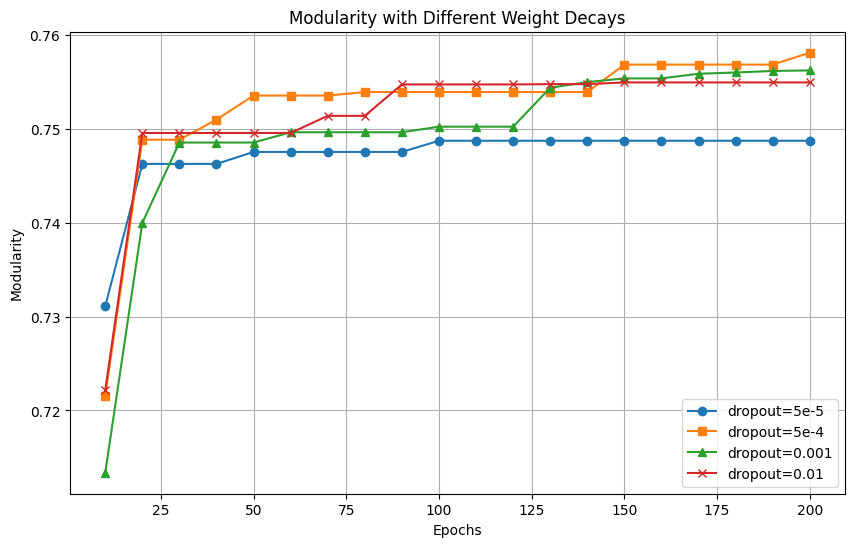

In [46]:
value_dropout_0#dropout=5e-5
value_dropout_1#dropout=5e-4
value_dropout_2#dropout=0.001
value_dropout_3#dropout=0.01
import matplotlib.pyplot as plt
import numpy as np

# 示例数据：每个学习率的训练值
epochs = np.arange(10, 201, 10)  # 从 10 到 200，步长为 10
# 创建图形和轴
plt.figure(figsize=(10, 6))

# 绘制每个学习率的训练值
plt.plot(epochs, value_dropout_0, label='dropout=5e-5', marker='o')
plt.plot(epochs, value_dropout_1[0:20], label='dropout=5e-4', marker='s')
plt.plot(epochs, value_dropout_2, label='dropout=0.001', marker='^')
plt.plot(epochs, value_dropout_3, label='dropout=0.01', marker='x')

# 添加标签和标题
plt.xlabel('Epochs')
plt.ylabel('Modularity')
plt.title('Modularity with Different Weight Decays')
plt.legend()  # 显示图例

# 显示图形
plt.grid(True)
plt.show()

In [39]:
model_cluster = GCNClusterNet(nfeat=50, nhid=128, nout=50, dropout=0.1, K=35, cluster_temp=20)
bin_adj_all = (adj.to_dense() > 0).float()
optimizer = torch.optim.Adam(model_cluster.parameters(), lr=0.001, weight_decay=5e-4)
test_object = make_modularity_matrix(bin_adj_all)
model_cluster.train()
num_cluster_iter = 1
losses = []
value_temp_1=[]
for epoch in range(200):
    mu, r, embeds, dist = model_cluster(features, adj, num_cluster_iter)
    loss = loss_modularity(r, bin_adj_all, test_object)
    loss = -loss
    optimizer.zero_grad()
    loss.backward()
    if epoch == 100:
        num_cluster_iter = 10
    if epoch % 100 == 0:
        r = torch.softmax(100 * r, dim=1)
    loss_test = loss_modularity(r, bin_adj_all, test_object)
    if epoch == 0:
        best_train_val = 100
    if loss.item() < best_train_val:
        best_train_val = loss.item()
        curr_test_loss = loss_test.item()
        # convert distances into a feasible (fractional x)#将距离转换为可行的（分数x）
        x_best = torch.softmax(dist * 100, 0).sum(dim=1)
        x_best = 2 * (torch.sigmoid(4 * x_best) - 0.5)
        if x_best.sum() > 5:
            x_best = 5 * x_best / x_best.sum()
    losses.append(loss.item())
    optimizer.step()
    if epoch%10==0:
        print(f'epoch{epoch + 1}   ClusterNet value:{curr_test_loss}')
        value_temp_1.append(curr_test_loss)

epoch1   ClusterNet value:0.7181130647659302
epoch11   ClusterNet value:0.7220660448074341
epoch21   ClusterNet value:0.7475156188011169
epoch31   ClusterNet value:0.7562524080276489
epoch41   ClusterNet value:0.7571572065353394
epoch51   ClusterNet value:0.7573697566986084
epoch61   ClusterNet value:0.757499098777771
epoch71   ClusterNet value:0.7575893402099609
epoch81   ClusterNet value:0.7576642036437988
epoch91   ClusterNet value:0.7577125430107117
epoch101   ClusterNet value:0.7577574849128723
epoch111   ClusterNet value:0.7578350901603699
epoch121   ClusterNet value:0.7578529715538025
epoch131   ClusterNet value:0.7578800916671753
epoch141   ClusterNet value:0.757902204990387
epoch151   ClusterNet value:0.7579495906829834
epoch161   ClusterNet value:0.7579946517944336
epoch171   ClusterNet value:0.7580127716064453
epoch181   ClusterNet value:0.7580390572547913
epoch191   ClusterNet value:0.7580581307411194


In [40]:
model_cluster = GCNClusterNet(nfeat=50, nhid=128, nout=50, dropout=0.1, K=35, cluster_temp=30)
bin_adj_all = (adj.to_dense() > 0).float()
optimizer = torch.optim.Adam(model_cluster.parameters(), lr=0.001, weight_decay=5e-4)
test_object = make_modularity_matrix(bin_adj_all)
model_cluster.train()
num_cluster_iter = 1
losses = []
value_temp_2=[]
for epoch in range(200):
    mu, r, embeds, dist = model_cluster(features, adj, num_cluster_iter)
    loss = loss_modularity(r, bin_adj_all, test_object)
    loss = -loss
    optimizer.zero_grad()
    loss.backward()
    if epoch == 100:
        num_cluster_iter = 10
    if epoch % 100 == 0:
        r = torch.softmax(100 * r, dim=1)
    loss_test = loss_modularity(r, bin_adj_all, test_object)
    if epoch == 0:
        best_train_val = 100
    if loss.item() < best_train_val:
        best_train_val = loss.item()
        curr_test_loss = loss_test.item()
        # convert distances into a feasible (fractional x)#将距离转换为可行的（分数x）
        x_best = torch.softmax(dist * 100, 0).sum(dim=1)
        x_best = 2 * (torch.sigmoid(4 * x_best) - 0.5)
        if x_best.sum() > 5:
            x_best = 5 * x_best / x_best.sum()
    losses.append(loss.item())
    optimizer.step()
    if epoch%10==0:
        print(f'epoch{epoch + 1}   ClusterNet value:{curr_test_loss}')
        value_temp_2.append(curr_test_loss)

epoch1   ClusterNet value:0.7037544250488281
epoch11   ClusterNet value:0.7391417622566223
epoch21   ClusterNet value:0.745258092880249
epoch31   ClusterNet value:0.7540693283081055
epoch41   ClusterNet value:0.7540693283081055
epoch51   ClusterNet value:0.7540693283081055
epoch61   ClusterNet value:0.7540693283081055
epoch71   ClusterNet value:0.7583955526351929
epoch81   ClusterNet value:0.7583955526351929
epoch91   ClusterNet value:0.7583955526351929
epoch101   ClusterNet value:0.7583955526351929
epoch111   ClusterNet value:0.7583955526351929
epoch121   ClusterNet value:0.7583955526351929
epoch131   ClusterNet value:0.7583955526351929
epoch141   ClusterNet value:0.7583955526351929
epoch151   ClusterNet value:0.7583955526351929
epoch161   ClusterNet value:0.7583955526351929
epoch171   ClusterNet value:0.7583955526351929
epoch181   ClusterNet value:0.7583955526351929
epoch191   ClusterNet value:0.7583955526351929


In [41]:
model_cluster = GCNClusterNet(nfeat=50, nhid=128, nout=50, dropout=0.1, K=35, cluster_temp=200)
bin_adj_all = (adj.to_dense() > 0).float()
optimizer = torch.optim.Adam(model_cluster.parameters(), lr=0.001, weight_decay=5e-4)
test_object = make_modularity_matrix(bin_adj_all)
model_cluster.train()
num_cluster_iter = 1
losses = []
value_temp_3=[]
for epoch in range(200):
    mu, r, embeds, dist = model_cluster(features, adj, num_cluster_iter)
    loss = loss_modularity(r, bin_adj_all, test_object)
    loss = -loss
    optimizer.zero_grad()
    loss.backward()
    if epoch == 100:
        num_cluster_iter = 10
    if epoch % 100 == 0:
        r = torch.softmax(100 * r, dim=1)
    loss_test = loss_modularity(r, bin_adj_all, test_object)
    if epoch == 0:
        best_train_val = 100
    if loss.item() < best_train_val:
        best_train_val = loss.item()
        curr_test_loss = loss_test.item()
        # convert distances into a feasible (fractional x)#将距离转换为可行的（分数x）
        x_best = torch.softmax(dist * 100, 0).sum(dim=1)
        x_best = 2 * (torch.sigmoid(4 * x_best) - 0.5)
        if x_best.sum() > 5:
            x_best = 5 * x_best / x_best.sum()
    losses.append(loss.item())
    optimizer.step()
    if epoch%10==0:
        print(f'epoch{epoch + 1}   ClusterNet value:{curr_test_loss}')
        value_temp_3.append(curr_test_loss)

epoch1   ClusterNet value:0.7349748611450195
epoch11   ClusterNet value:0.7215819358825684
epoch21   ClusterNet value:0.7284978628158569
epoch31   ClusterNet value:0.7284978628158569
epoch41   ClusterNet value:0.7284978628158569
epoch51   ClusterNet value:0.7398465871810913
epoch61   ClusterNet value:0.7398465871810913
epoch71   ClusterNet value:0.7398465871810913
epoch81   ClusterNet value:0.7398465871810913
epoch91   ClusterNet value:0.7398465871810913
epoch101   ClusterNet value:0.7398465871810913
epoch111   ClusterNet value:0.7398465871810913
epoch121   ClusterNet value:0.7398465871810913
epoch131   ClusterNet value:0.7398465871810913
epoch141   ClusterNet value:0.7398465871810913
epoch151   ClusterNet value:0.7398465871810913
epoch161   ClusterNet value:0.7398465871810913
epoch171   ClusterNet value:0.7398465871810913
epoch181   ClusterNet value:0.7398465871810913
epoch191   ClusterNet value:0.7398465871810913


In [42]:
model_cluster = GCNClusterNet(nfeat=50, nhid=128, nout=50, dropout=0.1, K=35, cluster_temp=100)
bin_adj_all = (adj.to_dense() > 0).float()
optimizer = torch.optim.Adam(model_cluster.parameters(), lr=0.001, weight_decay=5e-4)
test_object = make_modularity_matrix(bin_adj_all)
model_cluster.train()
num_cluster_iter = 1
losses = []
value_temp_4=[]
for epoch in range(200):
    mu, r, embeds, dist = model_cluster(features, adj, num_cluster_iter)
    loss = loss_modularity(r, bin_adj_all, test_object)
    loss = -loss
    optimizer.zero_grad()
    loss.backward()
    if epoch == 100:
        num_cluster_iter = 10
    if epoch % 100 == 0:
        r = torch.softmax(100 * r, dim=1)
    loss_test = loss_modularity(r, bin_adj_all, test_object)
    if epoch == 0:
        best_train_val = 100
    if loss.item() < best_train_val:
        best_train_val = loss.item()
        curr_test_loss = loss_test.item()
        # convert distances into a feasible (fractional x)#将距离转换为可行的（分数x）
        x_best = torch.softmax(dist * 100, 0).sum(dim=1)
        x_best = 2 * (torch.sigmoid(4 * x_best) - 0.5)
        if x_best.sum() > 5:
            x_best = 5 * x_best / x_best.sum()
    losses.append(loss.item())
    optimizer.step()
    if epoch%10==0:
        print(f'epoch{epoch + 1}   ClusterNet value:{curr_test_loss}')
        value_temp_4.append(curr_test_loss)

epoch1   ClusterNet value:0.7480946183204651
epoch11   ClusterNet value:0.74541175365448
epoch21   ClusterNet value:0.74541175365448
epoch31   ClusterNet value:0.74541175365448
epoch41   ClusterNet value:0.74541175365448
epoch51   ClusterNet value:0.745454728603363
epoch61   ClusterNet value:0.745454728603363
epoch71   ClusterNet value:0.750805139541626
epoch81   ClusterNet value:0.7554012537002563
epoch91   ClusterNet value:0.7554012537002563
epoch101   ClusterNet value:0.7554012537002563
epoch111   ClusterNet value:0.7554012537002563
epoch121   ClusterNet value:0.7554012537002563
epoch131   ClusterNet value:0.7554012537002563
epoch141   ClusterNet value:0.7554012537002563
epoch151   ClusterNet value:0.7554012537002563
epoch161   ClusterNet value:0.7554012537002563
epoch171   ClusterNet value:0.7554012537002563
epoch181   ClusterNet value:0.7554012537002563
epoch191   ClusterNet value:0.7554012537002563


In [43]:
model_cluster = GCNClusterNet(nfeat=50, nhid=128, nout=50, dropout=0.1, K=35, cluster_temp=50)
bin_adj_all = (adj.to_dense() > 0).float()
optimizer = torch.optim.Adam(model_cluster.parameters(), lr=0.001, weight_decay=5e-4)
test_object = make_modularity_matrix(bin_adj_all)
model_cluster.train()
num_cluster_iter = 1
losses = []
value_temp_5=[]
for epoch in range(200):
    mu, r, embeds, dist = model_cluster(features, adj, num_cluster_iter)
    loss = loss_modularity(r, bin_adj_all, test_object)
    loss = -loss
    optimizer.zero_grad()
    loss.backward()
    if epoch == 100:
        num_cluster_iter = 10
    if epoch % 100 == 0:
        r = torch.softmax(100 * r, dim=1)
    loss_test = loss_modularity(r, bin_adj_all, test_object)
    if epoch == 0:
        best_train_val = 100
    if loss.item() < best_train_val:
        best_train_val = loss.item()
        curr_test_loss = loss_test.item()
        # convert distances into a feasible (fractional x)#将距离转换为可行的（分数x）
        x_best = torch.softmax(dist * 100, 0).sum(dim=1)
        x_best = 2 * (torch.sigmoid(4 * x_best) - 0.5)
        if x_best.sum() > 5:
            x_best = 5 * x_best / x_best.sum()
    losses.append(loss.item())
    optimizer.step()
    if epoch%10==0:
        print(f'epoch{epoch + 1}   ClusterNet value:{curr_test_loss}')
        value_temp_5.append(curr_test_loss)

epoch1   ClusterNet value:0.7103627920150757
epoch11   ClusterNet value:0.7231937646865845
epoch21   ClusterNet value:0.7461713552474976
epoch31   ClusterNet value:0.749677300453186
epoch41   ClusterNet value:0.7535411715507507
epoch51   ClusterNet value:0.7535411715507507
epoch61   ClusterNet value:0.7535411715507507
epoch71   ClusterNet value:0.755747377872467
epoch81   ClusterNet value:0.755747377872467
epoch91   ClusterNet value:0.755747377872467
epoch101   ClusterNet value:0.755747377872467
epoch111   ClusterNet value:0.755747377872467
epoch121   ClusterNet value:0.7590599060058594
epoch131   ClusterNet value:0.7591102719306946
epoch141   ClusterNet value:0.7591102719306946
epoch151   ClusterNet value:0.7591102719306946
epoch161   ClusterNet value:0.7599375247955322
epoch171   ClusterNet value:0.7599375247955322
epoch181   ClusterNet value:0.7599375247955322
epoch191   ClusterNet value:0.7599375247955322


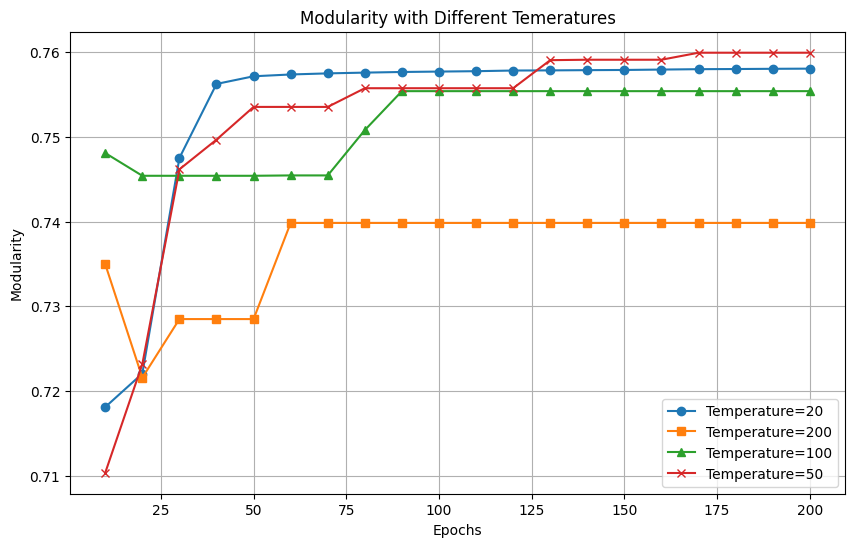

In [47]:
value_temp_1##temperature=20
value_temp_2##temperature=30
value_temp_3##temperature=200
value_temp_4##temperature=100
value_temp_5##temperature=50
import matplotlib.pyplot as plt
import numpy as np

# 示例数据：每个学习率的训练值
epochs = np.arange(10, 201, 10)  # 从 10 到 200，步长为 10
# 创建图形和轴
plt.figure(figsize=(10, 6))

# 绘制每个学习率的训练值
plt.plot(epochs,value_temp_1, label='Temperature=20', marker='o')
plt.plot(epochs, value_temp_3, label='Temperature=200', marker='s')
plt.plot(epochs, value_temp_4, label='Temperature=100', marker='^')
plt.plot(epochs, value_temp_5, label='Temperature=50', marker='x')

# 添加标签和标题
plt.xlabel('Epochs')
plt.ylabel('Modularity')
plt.title('Modularity with Different Temeratures')
plt.legend()  # 显示图例

# 显示图形
plt.grid(True)
plt.show()

In [48]:
model_cluster = GCNClusterNet(nfeat=50, nhid=128, nout=50, dropout=0.1, K=35, cluster_temp=50)
bin_adj_all = (adj.to_dense() > 0).float()
optimizer = torch.optim.Adam(model_cluster.parameters(), lr=0.001, weight_decay=5e-4)
test_object = make_modularity_matrix(bin_adj_all)
model_cluster.train()
num_cluster_iter = 1
losses = []
value_iter_0=[]
for epoch in range(200):
    mu, r, embeds, dist = model_cluster(features, adj, num_cluster_iter)
    loss = loss_modularity(r, bin_adj_all, test_object)
    loss = -loss
    optimizer.zero_grad()
    loss.backward()
    if epoch == 100:
        num_cluster_iter = 1
    if epoch % 100 == 0:
        r = torch.softmax(100 * r, dim=1)
    loss_test = loss_modularity(r, bin_adj_all, test_object)
    if epoch == 0:
        best_train_val = 100
    if loss.item() < best_train_val:
        best_train_val = loss.item()
        curr_test_loss = loss_test.item()
        # convert distances into a feasible (fractional x)#将距离转换为可行的（分数x）
        x_best = torch.softmax(dist * 100, 0).sum(dim=1)
        x_best = 2 * (torch.sigmoid(4 * x_best) - 0.5)
        if x_best.sum() > 5:
            x_best = 5 * x_best / x_best.sum()
    losses.append(loss.item())
    optimizer.step()
    if epoch%10==0:
        print(f'epoch{epoch + 1}   ClusterNet value:{curr_test_loss}')
        value_iter_0.append(curr_test_loss)

epoch1   ClusterNet value:0.7415275573730469
epoch11   ClusterNet value:0.7371543645858765
epoch21   ClusterNet value:0.7474824786186218
epoch31   ClusterNet value:0.7492136359214783
epoch41   ClusterNet value:0.7492136359214783
epoch51   ClusterNet value:0.7516144514083862
epoch61   ClusterNet value:0.7535171508789062
epoch71   ClusterNet value:0.7535171508789062
epoch81   ClusterNet value:0.7541205883026123
epoch91   ClusterNet value:0.7541205883026123
epoch101   ClusterNet value:0.7541205883026123
epoch111   ClusterNet value:0.7541205883026123
epoch121   ClusterNet value:0.7541205883026123
epoch131   ClusterNet value:0.7541205883026123
epoch141   ClusterNet value:0.7541205883026123
epoch151   ClusterNet value:0.7541205883026123
epoch161   ClusterNet value:0.7541205883026123
epoch171   ClusterNet value:0.7541205883026123
epoch181   ClusterNet value:0.7541205883026123
epoch191   ClusterNet value:0.7541205883026123


In [49]:
model_cluster = GCNClusterNet(nfeat=50, nhid=128, nout=50, dropout=0.1, K=35, cluster_temp=50)
bin_adj_all = (adj.to_dense() > 0).float()
optimizer = torch.optim.Adam(model_cluster.parameters(), lr=0.001, weight_decay=5e-4)
test_object = make_modularity_matrix(bin_adj_all)
model_cluster.train()
num_cluster_iter = 3
losses = []
value_iter_1=[]
for epoch in range(200):
    mu, r, embeds, dist = model_cluster(features, adj, num_cluster_iter)
    loss = loss_modularity(r, bin_adj_all, test_object)
    loss = -loss
    optimizer.zero_grad()
    loss.backward()
    if epoch == 100:
        num_cluster_iter = 3
    if epoch % 100 == 0:
        r = torch.softmax(100 * r, dim=1)
    loss_test = loss_modularity(r, bin_adj_all, test_object)
    if epoch == 0:
        best_train_val = 100
    if loss.item() < best_train_val:
        best_train_val = loss.item()
        curr_test_loss = loss_test.item()
        # convert distances into a feasible (fractional x)#将距离转换为可行的（分数x）
        x_best = torch.softmax(dist * 100, 0).sum(dim=1)
        x_best = 2 * (torch.sigmoid(4 * x_best) - 0.5)
        if x_best.sum() > 5:
            x_best = 5 * x_best / x_best.sum()
    losses.append(loss.item())
    optimizer.step()
    if epoch%10==0:
        print(f'epoch{epoch + 1}   ClusterNet value:{curr_test_loss}')
        value_iter_1.append(curr_test_loss)

epoch1   ClusterNet value:0.7366632223129272
epoch11   ClusterNet value:0.7397446036338806
epoch21   ClusterNet value:0.7493080496788025
epoch31   ClusterNet value:0.7523649334907532
epoch41   ClusterNet value:0.7523649334907532
epoch51   ClusterNet value:0.7547875046730042
epoch61   ClusterNet value:0.7547875046730042
epoch71   ClusterNet value:0.7559958100318909
epoch81   ClusterNet value:0.7559958100318909
epoch91   ClusterNet value:0.7559958100318909
epoch101   ClusterNet value:0.7572436332702637
epoch111   ClusterNet value:0.7581312656402588
epoch121   ClusterNet value:0.7581312656402588
epoch131   ClusterNet value:0.7581312656402588
epoch141   ClusterNet value:0.7581312656402588
epoch151   ClusterNet value:0.7581312656402588
epoch161   ClusterNet value:0.7581312656402588
epoch171   ClusterNet value:0.7581312656402588
epoch181   ClusterNet value:0.7581312656402588
epoch191   ClusterNet value:0.7581312656402588


In [50]:
model_cluster = GCNClusterNet(nfeat=50, nhid=128, nout=50, dropout=0.1, K=35, cluster_temp=50)
bin_adj_all = (adj.to_dense() > 0).float()
optimizer = torch.optim.Adam(model_cluster.parameters(), lr=0.001, weight_decay=5e-4)
test_object = make_modularity_matrix(bin_adj_all)
model_cluster.train()
num_cluster_iter = 1
losses = []
value_iter_2=[]
for epoch in range(200):
    mu, r, embeds, dist = model_cluster(features, adj, num_cluster_iter)
    loss = loss_modularity(r, bin_adj_all, test_object)
    loss = -loss
    optimizer.zero_grad()
    loss.backward()
    if epoch == 100:
        num_cluster_iter = 5
    if epoch % 100 == 0:
        r = torch.softmax(100 * r, dim=1)
    loss_test = loss_modularity(r, bin_adj_all, test_object)
    if epoch == 0:
        best_train_val = 100
    if loss.item() < best_train_val:
        best_train_val = loss.item()
        curr_test_loss = loss_test.item()
        # convert distances into a feasible (fractional x)#将距离转换为可行的（分数x）
        x_best = torch.softmax(dist * 100, 0).sum(dim=1)
        x_best = 2 * (torch.sigmoid(4 * x_best) - 0.5)
        if x_best.sum() > 5:
            x_best = 5 * x_best / x_best.sum()
    losses.append(loss.item())
    optimizer.step()
    if epoch%10==0:
        print(f'epoch{epoch + 1}   ClusterNet value:{curr_test_loss}')
        value_iter_2.append(curr_test_loss)

epoch1   ClusterNet value:0.7373563647270203
epoch11   ClusterNet value:0.7349693179130554
epoch21   ClusterNet value:0.7380395531654358
epoch31   ClusterNet value:0.7380395531654358
epoch41   ClusterNet value:0.7390515804290771
epoch51   ClusterNet value:0.7390515804290771
epoch61   ClusterNet value:0.7390515804290771
epoch71   ClusterNet value:0.741567075252533
epoch81   ClusterNet value:0.7430956363677979
epoch91   ClusterNet value:0.7430956363677979
epoch101   ClusterNet value:0.7430956363677979
epoch111   ClusterNet value:0.7473129034042358
epoch121   ClusterNet value:0.7477862238883972
epoch131   ClusterNet value:0.7477862238883972
epoch141   ClusterNet value:0.7491635680198669
epoch151   ClusterNet value:0.7492653131484985
epoch161   ClusterNet value:0.7492685914039612
epoch171   ClusterNet value:0.7492685914039612
epoch181   ClusterNet value:0.7492685914039612
epoch191   ClusterNet value:0.7493852972984314


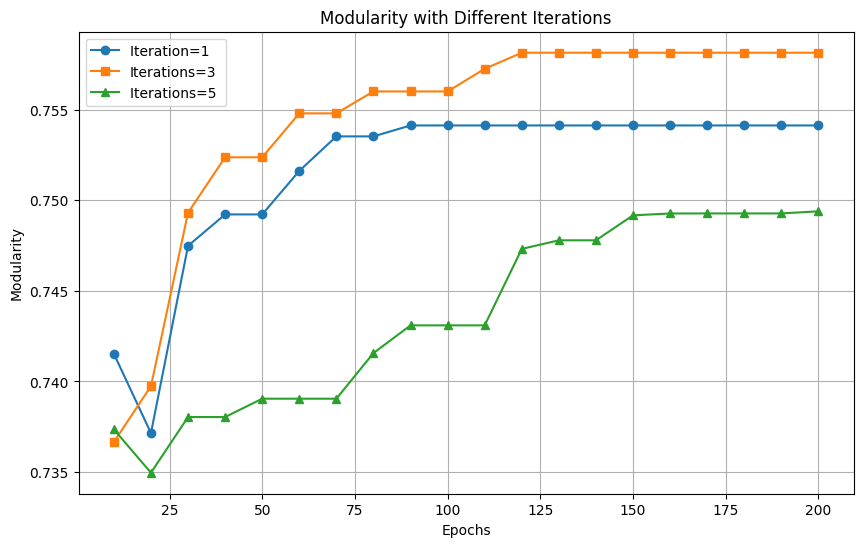

In [51]:
value_iter_0##Clustering Iterations=1 
value_iter_1##Clustering Iterations=3 
value_iter_2##Clustering Iterations=5 
import matplotlib.pyplot as plt
import numpy as np

# 示例数据：每个学习率的训练值
epochs = np.arange(10, 201, 10)  # 从 10 到 200，步长为 10
# 创建图形和轴
plt.figure(figsize=(10, 6))

# 绘制每个学习率的训练值
plt.plot(epochs,value_iter_0, label='Iteration=1 ', marker='o')
plt.plot(epochs, value_iter_1, label='Iterations=3', marker='s')
plt.plot(epochs, value_iter_2, label='Iterations=5 ', marker='^')

# 添加标签和标题
plt.xlabel('Epochs')
plt.ylabel('Modularity')
plt.title('Modularity with Different Iterations')
plt.legend()  # 显示图例

# 显示图形
plt.grid(True)
plt.show()